CLR stats
count    3.000000e+01
mean     2.321336e+06
std      3.124473e+05
min      1.928940e+06
25%      2.100117e+06
50%      2.236168e+06
75%      2.612896e+06
max      2.952450e+06
Name: het_snv, dtype: float64
NHR HiFi stats
count    1.400000e+01
mean     2.659138e+06
std      3.972090e+05
min      2.170775e+06
25%      2.371146e+06
50%      2.439917e+06
75%      3.072324e+06
max      3.176034e+06
Name: het_snv, dtype: float64
AFR stats
count    1.400000e+01
mean     2.922870e+06
std      1.695337e+05
min      2.714952e+06
25%      2.746669e+06
50%      2.948492e+06
75%      3.072324e+06
max      3.176034e+06
Name: het_snv, dtype: float64
Other stats
count    3.000000e+01
mean     2.198261e+06
std      1.421289e+05
min      1.928940e+06
25%      2.100117e+06
50%      2.209570e+06
75%      2.274131e+06
max      2.449876e+06
Name: het_snv, dtype: float64


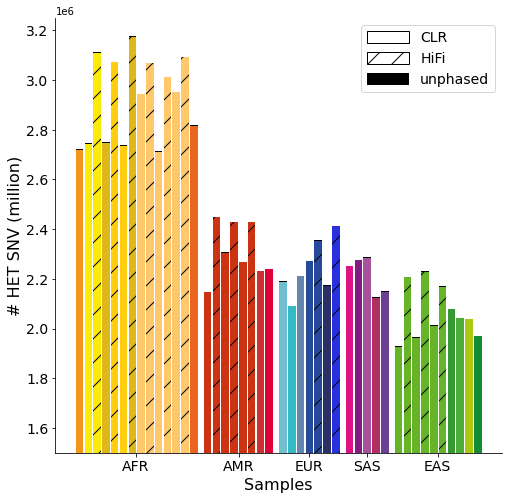

In [1]:
import os
import csv
import collections
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/fig1_panels/phasing_stats'
out_path = os.path.join(stats_path, pipeline_version, 'fig1_panel_phasing-stats')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))


def load_phasing_stats(file_path):
    stats = dict()
    with open(file_path, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for row in rows:
            if row['chromosome'] != 'ALL':
                continue
            het_var = int(row['heterozygous_variants'])
            het_snv = int(row['heterozygous_snvs'])
            phased_snv = int(row['phased_snvs'])
            assert het_var == het_snv, 'shit'
            stats['het_snv'] = het_snv
            stats['phased'] = phased_snv
            stats['phased_pct'] = round(phased_snv/het_snv * 100, 1)
    return stats


if not os.path.isfile(cache_file):
    stat_files = plot_aux.load_plot_data_files(
        stats_path,
        '.wh-phased.stats.tsv',
        pipeline_version)
    plot_data = [load_phasing_stats(fp) for fp in stat_files]

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in stat_files]
    row_index = []
    for sample, platform in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform))
    df = pd.DataFrame(plot_data, columns=['het_snv', 'phased', 'phased_pct'], index=row_index)
    df.index = pd.MultiIndex.from_tuples(df.index.values, names=['sample', 'super_pop', 'pop', 'platform'])
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform'])

errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print(sorted(missing))
    print('---------------')

print('==========')
nhr_clr = df.xs('CLR', level='platform', drop_level=False)
print('CLR stats')
print(nhr_clr['het_snv'].describe())
print('==========')
nhr_hifi = df.xs('HiFi', level='platform', drop_level=False)
print('NHR HiFi stats')
print(nhr_hifi['het_snv'].describe())
print('==========')

afr = df.xs('AFR', level='super_pop', drop_level=False)
print('AFR stats')
print(afr['het_snv'].describe())
print('==========')
other = df.drop('AFR', level='super_pop', inplace=False)
print('Other stats')
print(other['het_snv'].describe())


def plot_phasing_statistic(sample_stats):
    
    bar_width = prop('bar_width')

    fig, axis = plt.subplots(figsize=(8,8))
    
    value_collector = collections.defaultdict(list)
    x_pos_counter = 0
    
    x_pos_spop = collections.defaultdict(list)
    
    for sp in plot_aux.get_population_sorting():
        try:
            subset = sample_stats.xs(sp, level=1, drop_level=False)
        except KeyError:
            continue
        for index, row in subset.iterrows():
            color = rgbcodes[index[2]]
            phased = int(row['phased'])
            unphased = int(row['het_snv']) - phased            
            x_pos_counter += prop('bar_intra_spacing')

            value_collector[(index[3], 'unphased')].append(unphased)
            value_collector[(index[3], 'phased')].append(phased)
            value_collector[(index[3], 'colors')].append(color)
            value_collector[(index[3], 'x_pos')].append(x_pos_counter)
            x_pos_spop[sp].append(x_pos_counter)
        x_pos_counter += prop('bar_inter_spacing')
    
    for platform in ['HiFi', 'CLR']:
        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'phased')],
            bar_width,
            label='Phased',
            color=value_collector[(platform, 'colors')],
            hatch='/' if platform == 'HiFi' else None
        )

        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'unphased')],
            bar_width,
            bottom=value_collector[(platform, 'phased')],
            label='Unphased',
            color='black',
        )
    
    axis.set_xlabel(
        'Samples',
        fontsize=prop('fontsize_axis_label')
    )
    axis.set_ylabel(
        '# HET SNV (million)',
        fontsize=prop('fontsize_axis_label')
    )
    
    xticks = []
    for sp in plot_aux.get_population_sorting():
        xvals = x_pos_spop[sp]
        mid_pos = round((min(xvals) + max(xvals)) / 2, 1)
        xticks.append(mid_pos)
    
    axis.set_xticks(xticks)
    axis.set_xticklabels(plot_aux.get_population_sorting())
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    axis.set_ylim(1.5 * 1e6, 3.25 * 1e6)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_patches = [
#         patches.Patch(facecolor=rgbcodes['AFR'], edgecolor=None,
#                       label='AFR'),
#         patches.Patch(facecolor=rgbcodes['AMR'], edgecolor=None,
#                       label='AMR'),
#         patches.Patch(facecolor=rgbcodes['EAS'], edgecolor=None,
#                       label='EAS'),
#         patches.Patch(facecolor=rgbcodes['EUR'], edgecolor=None,
#                       label='EUR'),
#         patches.Patch(facecolor=rgbcodes['SAS'], edgecolor=None,
#                       label='SAS'),
#         patches.Patch(facecolor='white', edgecolor=None,
#                       label=''),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='CLR'),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='HiFi', hatch='/'),
        patches.Patch(facecolor='black', edgecolor=None,
                      label='unphased'),
    ]
    
    axis.legend(
        handles=custom_patches,
        loc='best',
        handlelength=3,
        handleheight=1,
        prop={'size': prop('fontsize_legend')}
    )
    
    if missing:
        plot_aux.add_incomplete_stamp(axis, 0.6, 0.7)
    
    return fig, []

fig, exart = plot_phasing_statistic(df)

fig.savefig(out_path + '.png', dpi=600, bbox_inches='tight', extra_artists=exart)
fig.savefig(out_path + '.svg', bbox_inches='tight', extra_artists=exart)
        
    